<a href="https://colab.research.google.com/github/leokan92/Contextual-bandit-Resnet-trading/blob/main/esqueleto_EP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exercício de Programação


##Importamos bibliotecas e dados necessários

In [46]:
import pandas as pd
import numpy as np

###Importamos dados Kaggle

In [47]:
# This is the path to the files downloaded from the M5 kaggle competition: https://www.kaggle.com/competitions/m5-forecasting-accuracy
files_path = '/content/drive/MyDrive/Aulas/Impacta/Aulas - Aprendizado de máquina/Aula 4/Case/Data/m5-forecasting-accuracy'

# Load the data (modify the file path as needed)
sales_data = pd.read_csv(f'{files_path}/sales_train_validation.csv')

###Cruzamento dos dados para dataset único

In [48]:
# Filter rows where 'id' column contains 'FOODS'
filtered_sales_data = sales_data[sales_data['id'].str.contains('FOODS')]
filtered_sales_data = filtered_sales_data[sales_data['state_id'].str.contains('CA')]

np.random.seed(0) # We fix the seed to aways have the same sample selection

# Sample 5 unique store IDs
unique_item_ids = filtered_sales_data['item_id'].unique()
unique_item_ids = np.random.choice(unique_item_ids, 10, replace=False)

filtered_sales_data = filtered_sales_data[filtered_sales_data['item_id'].isin(unique_item_ids)]

sales_data = filtered_sales_data.copy()
sales_data.reset_index(drop=True, inplace=True)

del filtered_sales_data

<ipython-input-48-382ccd6a69a7>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_sales_data = filtered_sales_data[sales_data['state_id'].str.contains('CA')]


In [49]:
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_1_036_CA_1_validation,FOODS_1_036,FOODS_1,FOODS,CA_1,CA,3,2,4,3,...,4,4,0,2,4,3,5,3,6,3
1,FOODS_1_054_CA_1_validation,FOODS_1_054,FOODS_1,FOODS,CA_1,CA,0,1,0,11,...,0,0,3,6,0,3,2,3,2,1
2,FOODS_2_018_CA_1_validation,FOODS_2_018,FOODS_2,FOODS,CA_1,CA,1,0,0,0,...,0,3,0,0,0,1,0,2,0,1
3,FOODS_2_273_CA_1_validation,FOODS_2_273,FOODS_2,FOODS,CA_1,CA,0,0,0,0,...,0,3,1,1,0,0,0,0,1,3
4,FOODS_2_303_CA_1_validation,FOODS_2_303,FOODS_2,FOODS,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


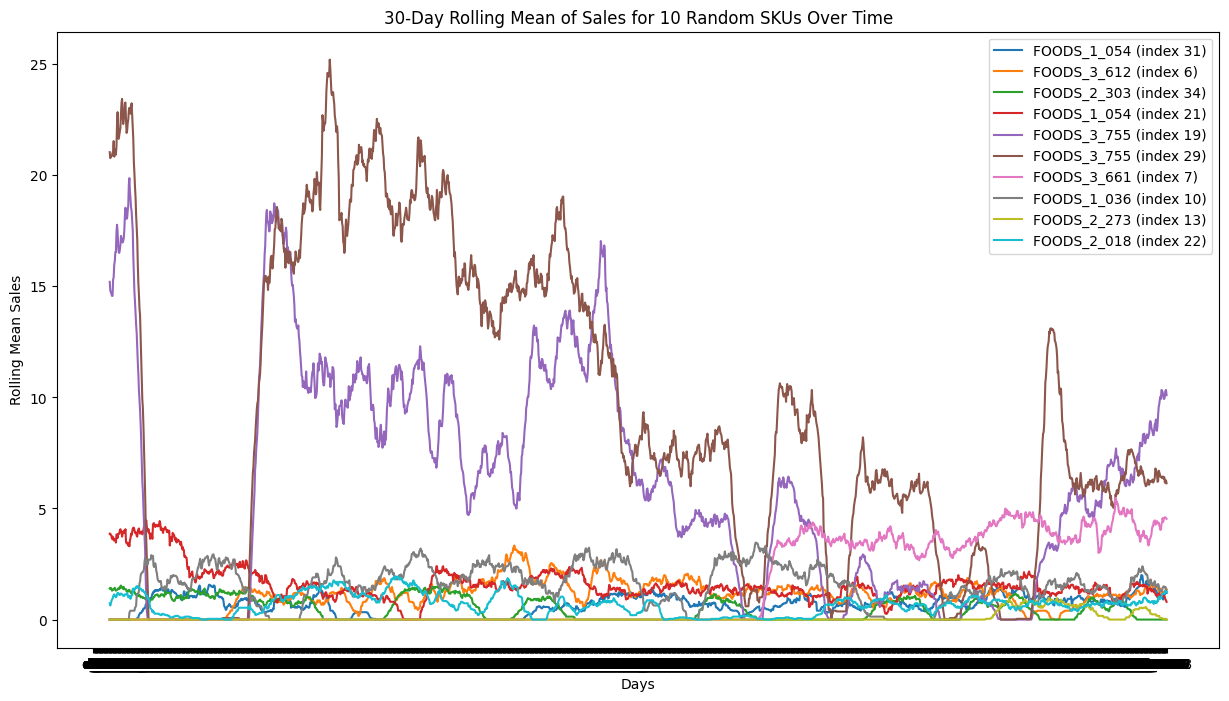

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'sales_data' is already loaded and contains columns like 'd_1', 'd_2', etc., representing daily sales

# Filter out non-sales columns
sales_only = sales_data.filter(regex='^d_', axis=1)

# Select 10 random SKUs
selected_skus_indices = np.random.choice(sales_data.index, 10, replace=False)
selected_skus_data = sales_only.loc[selected_skus_indices]

# Define the window for rolling mean
rolling_window = 30  # for example, a 30-day rolling window

# Plotting
plt.figure(figsize=(15, 8))
for i, sku_index in enumerate(selected_skus_indices):
    sku_id = sales_data.loc[sku_index, 'item_id']
    rolling_mean = selected_skus_data.loc[sku_index, :].rolling(window=rolling_window).mean()
    plt.plot(selected_skus_data.columns, rolling_mean, label=f'{sku_id} (index {sku_index})')

plt.title(f'30-Day Rolling Mean of Sales for 10 Random SKUs Over Time')
plt.xlabel('Days')
plt.ylabel('Rolling Mean Sales')
plt.legend()
plt.show()

del selected_skus_data
del selected_skus_indices
del sales_only

In [51]:
# Melt the sales data to long format
sales_long = pd.melt(sales_data,
                     id_vars=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                     var_name='day',
                     value_name='sale_qty')

# Extracting day numbers and converting to float first to handle NaN values
sales_long['day'] = sales_long['day'].str.extract('(\d+)').astype(float)

# You can check if there are any NaN values and handle them as needed
nan_count = sales_long['day'].isna().sum()
if nan_count > 0:
    print(f"There are {nan_count} NaN values in the 'day' column")

# Assuming we can drop NaN values (or you can handle them differently)
sales_long = sales_long.dropna(subset=['day'])

# Now safely convert to int
sales_long['day'] = sales_long['day'].astype(int)

sales_long.reset_index(drop=True, inplace=True)

del sales_data

There are 40 NaN values in the 'day' column


In [52]:
calendar_data = pd.read_csv(f'{files_path}/calendar.csv')

In [53]:
# Convert 'date' in the calendar DataFrame to a sequential day number
calendar_data['day'] = pd.to_datetime(calendar_data['date']).sub(pd.to_datetime(calendar_data['date'].iloc[0])).dt.days + 1

# Preview the calendar data
calendar_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,2
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,3
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,4
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,5


In [54]:
# Merge the sales_long and calendar DataFrames
merged_data_calendar = pd.merge(sales_long, calendar_data, on='day', how='left')
del calendar_data
del sales_long

In [55]:
price_data = pd.read_csv(f'{files_path}/sell_prices.csv')

In [56]:
# Merge sales and price data
merged_data = pd.merge(merged_data_calendar, price_data, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
del price_data
del merged_data_calendar

In [57]:
# Count the number of unique item_ids in the filtered_data DataFrame
unique_item_id_count = merged_data['item_id'].nunique()

# Print the count
print(f"Number of unique item_ids: {unique_item_id_count}")
del unique_item_id_count

Number of unique item_ids: 10


In [58]:
merged_data.columns

Index(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'day',
       'sale_qty', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

##Pré-Processamento

###Tratamento básico dos tipos de variáveis

In [59]:
# Identify the item_id with all NaN prices
item_ids_with_all_nan_prices = merged_data.groupby('item_id')['sell_price'].apply(lambda x: x.isna().all())

# Filtering out the item_ids to exclude (those with all NaN dates)
item_ids_to_exclude = item_ids_with_all_nan_prices[item_ids_with_all_nan_prices].index.tolist()

# Now filter out these item_ids from the merged_data
filtered_data = merged_data[~merged_data['item_id'].isin(item_ids_to_exclude)]

# Preview the filtered data
filtered_data.head()

,item_id,dept_id,cat_id,store_id,state_id,day,sale_qty,date,wm_yr_wk,weekday,...,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_1_036,FOODS_1,FOODS,CA_1,CA,1,3,2011-01-29,11101,Saturday,...,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1.50
1,FOODS_1_054,FOODS_1,FOODS,CA_1,CA,1,0,2011-01-29,11101,Saturday,...,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1.68
2,FOODS_2_018,FOODS_2,FOODS,CA_1,CA,1,1,2011-01-29,11101,Saturday,...,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,6.98
3,FOODS_2_273,FOODS_2,FOODS,CA_1,CA,1,0,2011-01-29,11101,Saturday,...,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN
4,FOODS_2_303,FOODS_2,FOODS,CA_1,CA,1,0,2011-01-29,11101,Saturday,...,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN


In [60]:
# Count the number of unique item_ids in the filtered_data DataFrame
unique_item_id_count = filtered_data['item_id'].nunique()

# Print the count
print(f"Number of unique item_ids: {unique_item_id_count}")

Number of unique item_ids: 10


In [61]:
# Ensure the data is sorted by date
filtered_data.sort_values(by='date', inplace=True)

# Create two Series: one filled forward and one filled backward
forward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='ffill')
backward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='bfill')

# Combine the results, preferring the forward fill
combined_fill = forward_filled.combine_first(backward_filled)

# Assign the combined result back to the sell_price column
filtered_data['sell_price'] = combined_fill

<ipython-input-61-a53922f40426>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='ffill')
<ipython-input-61-a53922f40426>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  backward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='bfill')


In [62]:
# Check if there are any remaining NaN values in sell_price
remaining_nan = filtered_data['sell_price'].isna().sum()
print(f"Remaining NaN values in sell_price: {remaining_nan}")

Remaining NaN values in sell_price: 0


In [63]:
del combined_fill
del backward_filled
del forward_filled
del item_ids_to_exclude
del item_ids_with_all_nan_prices

In [64]:
categorical_columns = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
                       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

for col in categorical_columns:
    filtered_data[col] = filtered_data[col].astype('category').cat.codes

In [65]:
filtered_data['year'] = filtered_data['year'] - filtered_data['year'].min()

In [66]:
filtered_data['weekday'] = filtered_data['weekday'].astype('category').cat.codes

In [67]:
data = filtered_data

In [68]:
window_sizes_lag = [1, 2, 3, 4, 5, 6, 7, 14, 30, 60]

for window in window_sizes_lag:
    data[f'lag_{window}'] = data.groupby(['item_id', 'store_id'])['sale_qty'].shift(window)

In [69]:
window_sizes_rolling = [2, 3, 4, 7, 14, 30, 60]

for window in window_sizes_rolling:
    rolling_mean = data.groupby(['item_id', 'store_id'])['sale_qty'].transform(lambda x: x.rolling(window=window).mean())
    rolling_sum = data.groupby(['item_id', 'store_id'])['sale_qty'].transform(lambda x: x.rolling(window=window).sum())

    data[f'rolling_mean_{window}'] = rolling_mean
    data[f'rolling_sum_{window}'] = rolling_sum

In [70]:
# Handling NaN values
data.dropna(inplace=True)
data.drop(['d'],axis = 1,inplace=True)

In [71]:
# Set option to display all columns
pd.set_option('display.max_columns', None)
data[(data['item_id'] == 1) & (data['store_id'] == 1)].head(5)

,item_id,dept_id,cat_id,store_id,state_id,day,sale_qty,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_14,lag_30,lag_60,rolling_mean_2,rolling_sum_2,rolling_mean_3,rolling_sum_3,rolling_mean_4,rolling_sum_4,rolling_mean_7,rolling_sum_7,rolling_mean_14,rolling_sum_14,rolling_mean_30,rolling_sum_30,rolling_mean_60,rolling_sum_60
2411,1,0,0,1,0,61,5,2011-03-30,11109,6,5,3,0,-1,-1,-1,-1,0,0,0,1.68,5,3,13,10,5,3,2,7,6,4,5.0,10.0,4.333333,13.0,6.5,26.0,6.285714,44.0,5.642857,79.0,5.200000,156.0,5.200000,312.0
2451,1,0,0,1,0,62,7,2011-03-31,11109,4,6,3,0,-1,-1,-1,-1,0,0,0,1.68,5,5,3,13,10,5,3,2,10,6,6.0,12.0,5.666667,17.0,5.0,20.0,6.857143,48.0,6.000000,84.0,5.100000,153.0,5.216667,313.0
2491,1,0,0,1,0,63,5,2011-04-01,11109,0,7,4,0,-1,-1,-1,-1,1,1,0,1.68,7,5,5,3,13,10,5,6,3,8,6.0,12.0,5.666667,17.0,5.5,22.0,6.857143,48.0,5.928571,83.0,5.166667,155.0,5.166667,310.0
2531,1,0,0,1,0,64,3,2011-04-02,11110,2,1,4,0,-1,-1,-1,-1,1,0,1,1.68,5,7,5,5,3,13,10,9,4,5,4.0,8.0,5.000000,15.0,5.0,20.0,5.857143,41.0,5.500000,77.0,5.133333,154.0,5.133333,308.0
2571,1,0,0,1,0,65,11,2011-04-03,11110,3,2,4,0,-1,-1,-1,-1,1,1,1,1.68,3,5,7,5,5,3,13,5,0,4,7.0,14.0,6.333333,19.0,6.5,26.0,5.571429,39.0,5.928571,83.0,5.500000,165.0,5.250000,315.0


In [72]:
# Ensure the data is sorted by date
filtered_data.sort_values(by='date', inplace=True)

# Create two Series: one filled forward and one filled backward
forward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='ffill')
backward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='bfill')

# Combine the results, preferring the forward fill
combined_fill = forward_filled.combine_first(backward_filled)

# Assign the combined result back to the sell_price column
filtered_data['sell_price'] = combined_fill

<ipython-input-72-a53922f40426>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='ffill')
<ipython-input-72-a53922f40426>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  backward_filled = filtered_data.groupby('item_id')['sell_price'].fillna(method='bfill')


###Quebra em conjunto de treino e teste

In [73]:
import pandas as pd

# Assuming 'data' is your DataFrame

# Create the target variable (next day's sale_qty)
data['target'] = data.groupby(['item_id', 'store_id'])['sale_qty'].shift(-1)

# Drop rows with NaN in target due to the shift operation
data.dropna(subset=['target'], inplace=True)

# Splitting the data into features and target
X = data.drop(['target', 'wm_yr_wk', 'date'], axis=1)
y = data['target']

# Lists to store individual DataFrames for concatenation
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Split index for each series
split_ratio = 0.8

for (item, store), group in data.groupby(['item_id', 'store_id']):
    split_index = int(len(group) * split_ratio)

    X_train_list.append(group.iloc[:split_index].drop(['target', 'wm_yr_wk', 'date'], axis=1))
    X_test_list.append(group.iloc[split_index:].drop(['target', 'wm_yr_wk', 'date'], axis=1))
    y_train_list.append(group.iloc[:split_index]['target'])
    y_test_list.append(group.iloc[split_index:]['target'])

# Concatenate all individual DataFrames
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)


In [74]:
from sklearn.preprocessing import StandardScaler

# List of continuous columns to scale
non_continuous_columns = categorical_columns + ['d', 'date','wm_yr_wk']

continuous_columns = X_train.columns.difference(non_continuous_columns)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the continuous variables of the training data
scaler.fit(X_train[continuous_columns])

# Transform the continuous variables in both training and test sets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_columns] = scaler.transform(X_train[continuous_columns])
X_test_scaled[continuous_columns] = scaler.transform(X_test[continuous_columns])

In [75]:
# Convert features to numeric type
numeric_features = ['sale_qty', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_14', 'lag_30', 'lag_60']
X_train[numeric_features] = X_train[numeric_features].apply(pd.to_numeric, errors='coerce')
X_test[numeric_features] = X_test[numeric_features].apply(pd.to_numeric, errors='coerce')

# After converting, you may need to drop NaN values that were introduced during conversion
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Convert the target variable to numeric type
y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

# After converting, you may need to drop NaN values that were introduced during conversion
y_train.dropna(inplace=True)
y_test.dropna(inplace=True)

##Análise das séries de tempo

###Decomposição da série temporal

Realize a decomposição da série temporal na 4 componentes apresentadas em aula

Escreva uma discussão em torno das características desta série de tempo.

###Tipo de modelo clássico

Qual tipo de modelo melhor descreve a série de tempo? Multiplicativo ou aditivo?

##ARIMA

Vamos realizar a previsão da série de tempo dos 10 produtos diferentes usando ARIMA

### Métricas de erro

Gere as seguintes métricas de erro comparando o realizado com o previsto pelo modelo: MAE, RMSE, MAPE (caso hajam valores zerados, usar NMAE ou trocar de série) e MSE.

##Holt-Winter

Vamos realizar a previsão da série de tempo dos 10 produtos diferentes usando Holt-Winter

###Métricas de erro

Gere as seguintes métricas de erro comparando o realizado com o previsto pelo modelo: MAE, RMSE, MAPE (caso hajam valores zerados, usar NMAE ou trocar de série) e MSE.

## Regressão linear multivariada

Utilize a regressão linear multivariada para realizar a previsão da série de tempo.

### Métricas de erro

Gere as seguintes métricas de erro comparando o realizado com o previsto pelo modelo: MAE, RMSE, MAPE (caso hajam valores zerados, usar NMAE ou trocar de série) e MSE.

## Outros modelos de regressão

Utilize algum outro modelo de regressão multivariado para realizar a previsão da série de tempo. Tente bater as métricas de erro dos modelos anteriores. Caso esteja dificil experimente trocar a série de tempo analisa entre alguma das outras 10 séries.

###Métricas de erro

Gere as seguintes métricas de erro comparando o realizado com o previsto pelo modelo: MAE, RMSE, MAPE (caso hajam valores zerados, usar NMAE ou trocar de série) e MSE.

##Vizualização de dados

Vamos vizualizar as previsões com o realizardo. Mostre usando Matplotlib ou mesmo Seaborn a comparação entre as previsões feitas por você neste exercício e o realizard (y_test). Caso queira e ache interessa, gere outros tipos de gráficos que ajutem a justicar a discussão a seguir.

##Discussão

Usando os resultados obtidos e os gráfico(s) gerados, gere uma discussão (pelo menos 2 parágrafos com mais de 5 linhas cada) que descreva os resultado obtidos e dê possíveis causas para que um determinado modelo tenha desempenhado melhor do que outros. Caso ache interessante, comente o resultado obtido para outras séries de tempo testada entre as 10 disponíveis.

Algumas possíveis perguntas que podem ajudar na elaboração da discussão:

1) Ao utilizar multivariaveis, houve algum ganho nas métricas de erros dos modelos linear e o modelo escolhido?

2) Quais foram as váriaveis que mais trouxeram informações para o modelo?

3) Quais sugestões de outro possíveis modelos e tratamento de dados par que possamos melhorar o desempenho dos modelos?

4) Como foram os resultados de todos os modelos no geral?

5) Entre os modelos que foram pior, qual você acredita que tenha sido a causa?